## Learning the progression and clinical subtypes of Alzheimer's disease from longitudinal clinical data
### Authors

Vipul Satone$^{1}$, Rachneet Kaur$^{1}$, Faraz Faghri$^{2, 3}$,  Mike A Nalls$^{2}$, Andrew B Singleton$^{2}$, Roy H. Campbell$^{3}$ 

1 - Department of Industrial and Enterprise Systems Engineering, University of Illinois Urbana-Champaign, IL, 61820, USA

2 - Laboratory of Neurogenetics, National Institute on Aging, National Institutes of Health, MD, 20892, USA

3 - Department of Computer Science, University of Illinois Urbana-Champaign, IL, 61820, USA

### Abstract

Alzheimer's disease (AD) is a degenerative brain disease impairing a person's ability to perform day to day activities. The clinical manifestations of Alzheimer's disease are characterized by heterogeneity in age, disease span, progression rate, impairment of memory and cognitive abilities. Due to these variabilities, personalized care and treatment planning, as well as patient counseling about their individual progression is limited. Recent developments in machine learning to detect hidden patterns in complex, multi-dimensional datasets provides significant opportunities to address this critical need. In this work, we use unsupervised and supervised machine learning approaches for subtype identification and prediction. We apply machine learning methods to the extensive clinical observations available at the Alzheimer's Disease Neuroimaging Initiative (ADNI) data set to identify patient subtypes and to predict disease progression. Our analysis depicts the progression space for the Alzheimer's disease into low, moderate and high disease progression zones. The proposed work will enable early detection and characterization of distinct disease subtypes based on clinical heterogeneity. We anticipate that our models will enable patient counseling, clinical trial design, and ultimately individualized clinical care.

In [53]:
#Importing libraries 
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 
import pandas as pd
from sklearn import decomposition
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
mpl.style.use('seaborn-colorblind')
import imageio
import warnings
warnings.filterwarnings("ignore")
sns.set()

%matplotlib inline

In [54]:
#Keeping the directory correct
import os
os.chdir('C:\\Users\\Vipul Satone\\health data') # default directory
address = "C:\\Users\\Vipul Satone\\health data\\ADNI\\final_code\\commented code\\all_code_alzheimer's\\" # directory where images are to be stored
# Inside this folder (m24_m12) have a folder gif. Inside this folder have three different folders named ica, pca, nmf.


In [55]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12']

In [56]:

# Following function gives information about dataset to be imputed.
def data_info(dataset):
    print('Name of dataset is: ' + dataset.name) 
    print('\n0th level of columns is ')
    print(list(pd.Series(dataset.columns.get_level_values(0)).unique()) )
    print('\n1st level of columns is: ')
    print(list(pd.Series(dataset.columns.get_level_values(1)).unique()) )
    print('\nShape of datset is:')
    print(dataset.shape)
    print('\nTotal number of missing values: ')
    print(dataset.isnull().sum().sum())
    
    

# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    Train1 = pd.DataFrame(Train1)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1


#### Reading the data-sets

Clinical Dementia rating

In [57]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
print(cdr1.shape)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '___' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr

cdr.name = 'Clinical Dementia Rating'

(10414, 7)


Neurological Battery

In [58]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
print(neurobat_1.shape)
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
#data_info(neurobat_clock)

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
#data_info(neurobat_copy)

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
#data_info(neurobat_limm_story)

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
#data_info(neurobat_dspan)

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
#data_info(neurobat_cat_flu)

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
#data_info(neurobat_trail)

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
#data_info(neurobat_av)

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
#data_info(neurobat_digit_score)

cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
neurobat_logical_memory = neurobat_logical_memory.unstack()
neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
#data_info(neurobat_logical_memory)

cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
#data_info(neurobat_boston_naming_test)

cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
#data_info(neurobat_anrt)

neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '___' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1

neurobat = neurobat1

neurobat.name = 'Neuropsychological Battery (All combined)'



(12484, 48)


MIni Mental State exam

In [59]:
#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
print(mmse1.shape)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 10) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 20) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T

# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '___' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T


mmse_no_encoding = mmse
## Hot encoding
#mmse_name_list = list( mmse.columns )
#mmse_empty = pd.DataFrame()
#for i in range(len(mmse_name_list)):
#    name = mmse_name_list[i]
#    mmse_with_dummies = pd.get_dummies(mmse[name], sparse=True, drop_first=True, prefix=name)
#    mmse_empty = pd.concat([mmse_empty,mmse_with_dummies] , axis = 1)   
mmse = mmse_no_encoding    
mmse.name = 'Mini Mental State Exam'

(10617, 1)


Geriatric Depression scale

In [60]:
#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
print(geriatric1.shape)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '___' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric

geriatric.name = 'Geriatric depression scale'


(9486, 2)


Crane Lab (UW) Neuropsych Summary Score

In [61]:
#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
print(uwn1.shape)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(list_months_to_be_considered)].T



# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '___' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn
uwn.name = 'Crane Lab (UW) Neuropsych Summary Score'

(9207, 2)


Neuropsychiatric Inventory (NPI)

In [62]:
#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
print(npi1.shape)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T

# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '___' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all


(4447, 12)


Monteral cognitive assessment

In [63]:
#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
print(moca1.shape)
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '___' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca


## Hot encoding
#moca_name_list = list( moca.columns )
#moca_empty = pd.DataFrame()
#for i in range(len(moca_name_list)):
#    name = moca_name_list[i]
#    moca_with_dummies = pd.get_dummies(moca[name], sparse=True, drop_first=True, prefix=name)
#    indexex = moca_with_dummies.index 
#    moca_empty = pd.concat([moca_empty,moca_with_dummies] , axis = 1)  
#moca = moca_empty        

moca = moca_no_encoding
moca.name = 'Montreal Cognitive Assessment'

(5509, 10)


Functinal assesment questionair

In [64]:
#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
print(faq1.shape)
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '___' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq

## Hot encoding
#faq_name_list = list( faq.columns )
#faq_empty = pd.DataFrame()
#for i in range(len(faq_name_list)):
#    name = faq_name_list[i]
#    faq_with_dummies = pd.get_dummies(faq[name], sparse=True, drop_first=True, prefix=name)
#    faq_empty = pd.concat([faq_empty,faq_with_dummies] , axis = 1)
#faq = faq_empty    
faq = faq_no_encoding
faq.name = 'Functional Assessment Questionnaire'


(9525, 1)


Everyday cognition - study partner

In [65]:
#ECOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
print(ecogpt1.shape)
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.replace({9: None })
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
 
ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )



# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf


## Hot encoding
#ecogpt_name_list = list( ecogpt.columns )
#ecogpt_empty = pd.DataFrame()
#for i in range(len(ecogpt_name_list)):
#    name = ecogpt_name_list[i]
#    ecogpt_with_dummies = pd.get_dummies(ecogpt[name], sparse=True, drop_first=True, prefix=name)
#    ecogpt_empty = pd.concat([ecogpt_empty,ecogpt_with_dummies] , axis = 1)
#    
ecogpt = ecogpt_no_encoding   
ecogpt.name = 'Everyday cognition - study partner'

(5238, 40)


Everyday cognition - self

In [66]:
#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogsp = ecogsp.replace({9: None })
ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
 
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf

## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
ecogsp = ecogsp_no_encoding   
ecogsp.name = 'Everyday cognition - self'

(5463, 40)


In [67]:

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' ]
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])

size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )
             
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols

for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' ]

print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq'] :
************************


#### Projecting data Using PCA, ICA, NMF

In [68]:
def project_data(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    print('Start...')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    print('Shape of dataset is {}'.format(M_chosen.shape) )
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('PCA done')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('ICA Done')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('NMF Done')
    print('End...')
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.5) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.5) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "all_2d_list.csv")     
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia', 'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9,10,11], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta','white','firebrick'])
    return redued, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3




def project_data2(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    
    print('Start...')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_chosen_return = M_chosen.copy(deep = True)
    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('PCA done')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('ICA done')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('NMF done')
    return M_W, M_chosen_return

### Curve fitting on full data. 
For this all the data was selected till m24 (Data was considered even if its labels were not available, because in this case we don't need labels)
For fitting the curve on projected data the projected data the degree of the curve was decided using AIC. 
Two type of linear cures were fitted.

Using matplotlib backend: Qt5Agg
Start...
(583, 218)
PCA done
ICA done
NMF done
Results for order 1 
-1740.7943246725436
Intercept    0.788400
X_poly      -1.195395
dtype: float64
Results for order 3 
-1818.954838284155
Intercept    0.729322
X_poly[0]   -0.398741
X_poly[1]   -2.253950
X_poly[2]    1.758491
dtype: float64


-1.1953946898550045

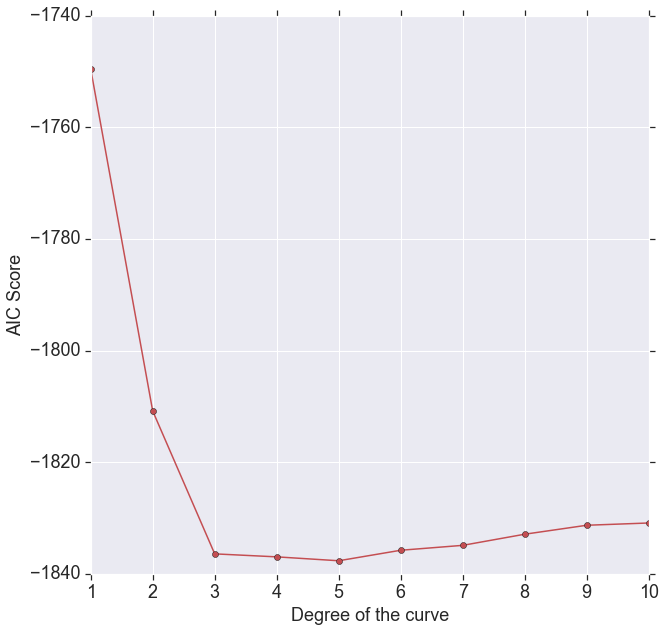

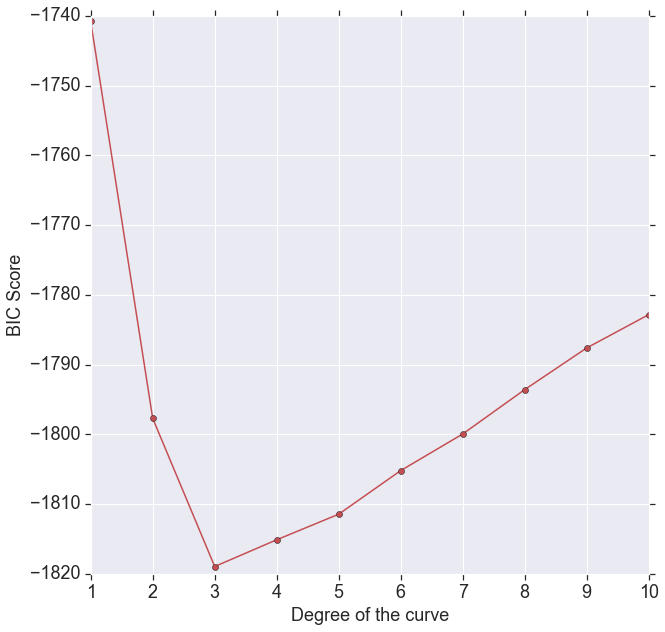

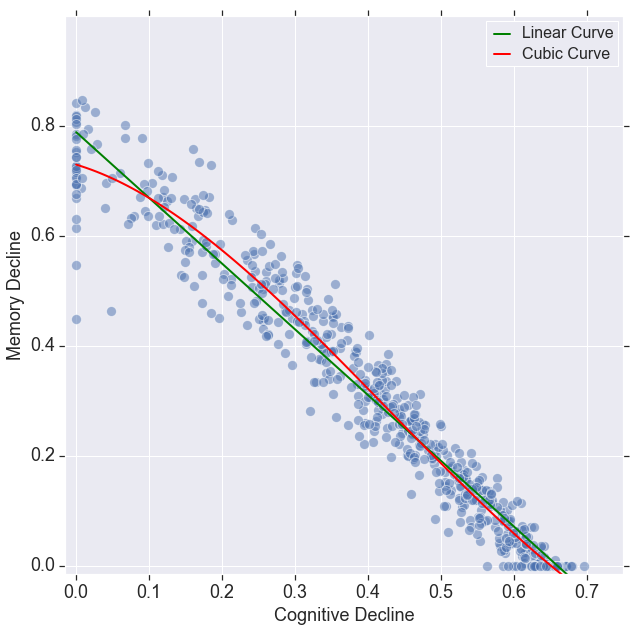

In [69]:
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
%matplotlib auto

def fit_curve(redued_item_24, order1 , order2, string):
    x = np.asarray(redued_item_24['NMF_2_1'],dtype=float).reshape(-1, 1)
    y = np.asarray( redued_item_24['NMF_2_2'] , dtype=float).reshape(-1, 1)
    
    data = pd.DataFrame(x,columns=['x'])
    data['y'] = y
    
    poly_reg = PolynomialFeatures(degree = 2)
    X_poly = poly_reg.fit_transform(x)
    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly, y)
    
    
    bic_value = []
    for i in range(10):
        degree = i+1
        poly_reg = PolynomialFeatures(degree = degree, include_bias= False )
        X_poly = poly_reg.fit_transform(x)
        model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
        model.params
        model.conf_int()
        model.pvalues
        bic_value.append(model.bic)
#        print(model.bic)
    
    aic_value = []
    for i in range(10):
        degree = i+1
        poly_reg = PolynomialFeatures(degree = degree, include_bias= False )
        X_poly = poly_reg.fit_transform(x)
        model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
        model.params
        model.conf_int()
        model.pvalues
        aic_value.append(model.aic)
#        print(model.aic)
    fig1,ax1 = plt.subplots(figsize=(10, 10))
    ax1.plot((range(1,11)),aic_value,  'ro-')
    ax1.set_xlabel("Degree of the curve",fontsize=18)
    ax1.set_ylabel("AIC Score",fontsize=18)
    ax1.tick_params(labelsize=18)
    plt.savefig(address + string + 'AIC_.png',dpi = 200)
    
    fig2,ax2 = plt.subplots(figsize=(10, 10))
    ax2.plot((range(1,11)),bic_value, 'ro-')
    ax2.set_xlabel("Degree of the curve",fontsize=18)
    ax2.set_ylabel("BIC Score",fontsize=18)
    ax2.tick_params(labelsize=18)
    plt.savefig(address + string + 'BIC_.png',dpi = 200)
     
    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x)
    model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
    model.conf_int()
    model.pvalues
    print('Results for order {} '.format(order1))
    print(model.bic)
    print(model.params)
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order2, include_bias= False )
    X_poly = poly_reg.fit_transform(x)
    model = sm.ols(formula = 'y ~ X_poly', data = data).fit()
    model.conf_int()
    model.pvalues
    print('Results for order {} '.format(order2))
    print(model.bic)
    print(model.params)
    a3 = model.params
    
    
    x_new = np.linspace(min(x), max(x), 100)
#    y_new = a[0] + (a[1]*x_new) # slope = -51
#    y_new3 = a3[0] + (a3[1]*x_new) + (a3[2]*( (x_new)**2)) +  (a3[3]*( (x_new)**3)) 
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order2+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(10, 10))
    ax3.scatter(x,y, s= 100, alpha = 0.5)
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Linear Curve')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Cubic Curve')
    ax3.set_xlim([-0.015, 0.75])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=18)
    ax3.set_ylabel("Memory Decline",fontsize=18)
    ax3.legend()
    plt.setp(ax3.get_legend().get_texts(), fontsize='16')
    plt.savefig(address + string + 'Curve_fitting_.png',dpi = 200)
    return a[1]



visits = 'm24'
redued_item_24,_ = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
fit_curve(redued_item_24 ,1,3, 'full_data_')

#### Projcting the most and least educated observations on the projection plane to find any differences.
Slope of fitted curve for most and least educated people is different.

Start...
(583, 218)
PCA done
ICA done
NMF done
Results for order1
-596.0732829072234
Intercept    0.829502
X_poly      -1.263835
dtype: float64
Results for order3
-637.9927278031724
Intercept    0.776902
X_poly      -1.193672
dtype: float64


-1.2638350589767742

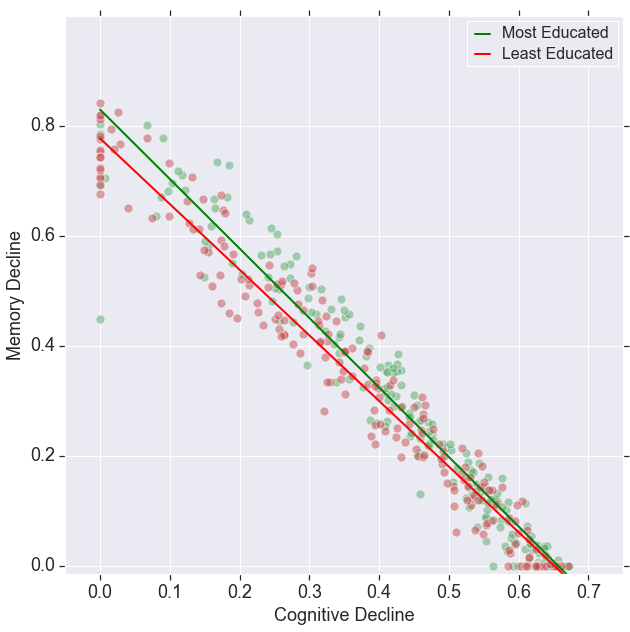

In [70]:
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def fit_curve_2(redued_item_24, order1 , order2, string):
    result_more = redued_item_24.iloc[-200:,:]
    result_less = redued_item_24.iloc[0:200,:]
    x_m = np.asarray(result_more['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_m = np.asarray( result_more['NMF_2_2'] , dtype=float).reshape(-1, 1)
    x_l = np.asarray(result_less['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_l = np.asarray( result_less['NMF_2_2'] , dtype=float).reshape(-1, 1)    
    
    data_m = pd.DataFrame(x_m,columns=['x'])
    data_m['y'] = y_m
    data_l = pd.DataFrame(x_l,columns=['x'])
    data_l['y'] = y_l    

    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_m)
    model = sm.ols(formula = 'y ~ X_poly', data = data_m).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order1))
    print(model.bic)
    print(model.params)
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_l)
    model = sm.ols(formula = 'y ~ X_poly', data = data_l).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order2))
    print(model.bic)
    print(model.params)
    a3 = model.params
    
    x_new = np.linspace(min(x_l), max(x_m), 100)
#    y_new = a[0] + (a[1]*x_new) # slope = -51
#    y_new3 = a3[0] + (a3[1]*x_new) + (a3[2]*( (x_new)**2)) +  (a3[3]*( (x_new)**3)) 
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order1+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(10, 10))
    ax3.scatter(x_m,y_m, s= 80, alpha = 0.5, c = 'g')
    ax3.scatter(x_l,y_l, s= 80, alpha = 0.5 , c = 'r')
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Most Educated')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Least Educated')
    ax3.set_xlim([-0.05, 0.75])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=18)
    ax3.set_ylabel("Memory Decline",fontsize=18)
    ax3.legend()
    plt.setp(ax3.get_legend().get_texts(), fontsize='16')
    plt.savefig(address + string + 'Curve_fitting_.png',dpi = 200)
    return a[1]

# Full data
redued_item_24, _ = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] 
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
slope_edu_less = []
slope_edu_greater = []

result = result.sort_values(by=['PTEDUCAT'])
fit_curve_2(result,1,3,'Education_difference_')

## Male female

Start...
(583, 218)
PCA done
ICA done
NMF done
Results for order1
-924.8222382040544
Intercept    0.785764
X_poly      -1.183834
dtype: float64
Results for order3
-808.6795092562534
Intercept    0.790753
X_poly      -1.205491
dtype: float64


-1.1838338071468806

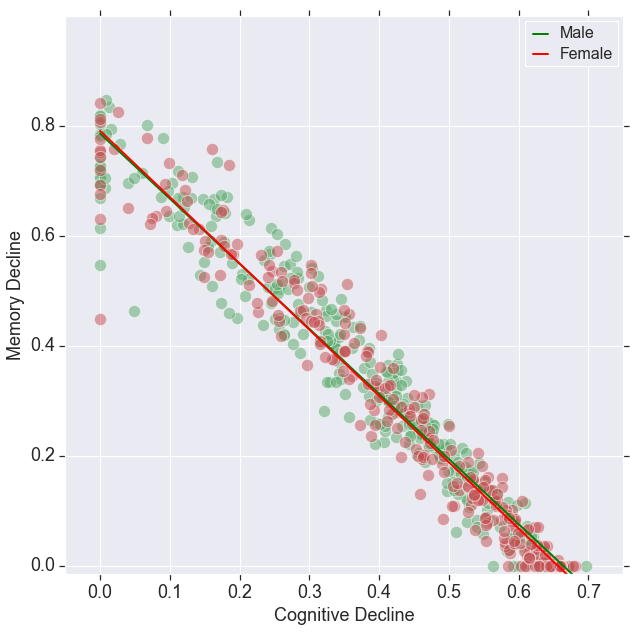

In [71]:
def fit_curve_3(redued_item_24, order1 , order2, string):
    
    result_more = female_samples = result[result['PTGENDER'] == 'Male']
    result_less = female_samples = result[result['PTGENDER'] == 'Female']
    x_m = np.asarray(result_more['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_m = np.asarray( result_more['NMF_2_2'] , dtype=float).reshape(-1, 1)
    x_l = np.asarray(result_less['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_l = np.asarray( result_less['NMF_2_2'] , dtype=float).reshape(-1, 1)    
    
    data_m = pd.DataFrame(x_m,columns=['x'])
    data_m['y'] = y_m
    data_l = pd.DataFrame(x_l,columns=['x'])
    data_l['y'] = y_l    

    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_m)
    model = sm.ols(formula = 'y ~ X_poly', data = data_m).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order1))
    print(model.bic)
    print(model.params)
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_l)
    model = sm.ols(formula = 'y ~ X_poly', data = data_l).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order2))
    print(model.bic)
    print(model.params)
    a3 = model.params
    
    x_new = np.linspace(min(x_l), max(x_m), 100)
#    y_new = a[0] + (a[1]*x_new) # slope = -51
#    y_new3 = a3[0] + (a3[1]*x_new) + (a3[2]*( (x_new)**2)) +  (a3[3]*( (x_new)**3)) 
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order1+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(10, 10))
    ax3.scatter(x_m,y_m, s= 150, alpha = 0.5, c = 'g')
    ax3.scatter(x_l,y_l, s= 150, alpha = 0.5 , c = 'r')
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Male')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Female')
    ax3.set_xlim([-0.05, 0.75])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=18)
    ax3.set_ylabel("Memory Decline",fontsize=18)
    ax3.legend()
    plt.setp(ax3.get_legend().get_texts(), fontsize='16')
    plt.savefig(address + string + 'Curve_fitting_.png',dpi = 200)
    return a[1]




# Full data
redued_item_24,_ = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] 
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
fit_curve_3(result, 1 , 3, 'Gender_')




#### Age Effect
Looking for effect of age in progeression space.

Start...
(583, 218)
PCA done
ICA done
NMF done
Results for order1
-273.81264315115413
Intercept    0.794573
X_poly      -1.205517
dtype: float64
Results for order3
-697.4712526705292
Intercept    0.800545
X_poly      -1.210745
dtype: float64


-1.2055170575145053

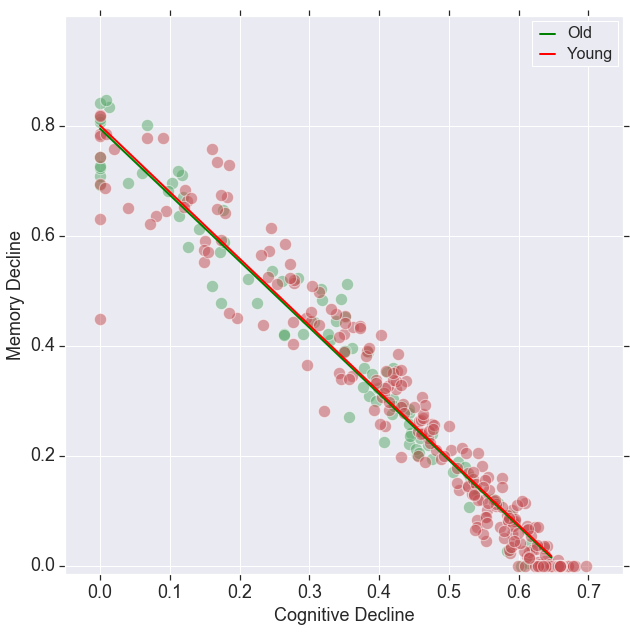

In [72]:
def fit_curve_4(redued_item_24, order1 , order2, string):
    
    result_more = result[result['AGE'] >= 80]
    result_less = result[result['AGE'] <= 71]
    x_m = np.asarray(result_more['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_m = np.asarray( result_more['NMF_2_2'] , dtype=float).reshape(-1, 1)
    x_l = np.asarray(result_less['NMF_2_1'],dtype=float).reshape(-1, 1)
    y_l = np.asarray( result_less['NMF_2_2'] , dtype=float).reshape(-1, 1)    
    
    data_m = pd.DataFrame(x_m,columns=['x'])
    data_m['y'] = y_m
    data_l = pd.DataFrame(x_l,columns=['x'])
    data_l['y'] = y_l    

    # linear model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_m)
    model = sm.ols(formula = 'y ~ X_poly', data = data_m).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order1))
    print(model.bic)
    print(model.params)
    a = model.params
    
    # cubic model
    poly_reg = PolynomialFeatures(degree = order1, include_bias= False )
    X_poly = poly_reg.fit_transform(x_l)
    model = sm.ols(formula = 'y ~ X_poly', data = data_l).fit()
    model.conf_int()
    model.pvalues
    print('Results for order{}'.format(order2))
    print(model.bic)
    print(model.params)
    a3 = model.params
    
    x_new = np.linspace(min(x_l), max(x_m), 100)
#    y_new = a[0] + (a[1]*x_new) # slope = -51
#    y_new3 = a3[0] + (a3[1]*x_new) + (a3[2]*( (x_new)**2)) +  (a3[3]*( (x_new)**3)) 
    y_new = 0
    y_new3 = 0
    for i in range(order1+1):
        y_new += a[i]*(x_new**i)
    for j in range(order1+1):
        y_new3 += a3[j]*(x_new**j)
    fig3,ax3 = plt.subplots(figsize=(10, 10))
    ax3.scatter(x_m,y_m, s= 150, alpha = 0.5, c = 'g')
    ax3.scatter(x_l,y_l, s= 150, alpha = 0.5 , c = 'r')
    ax3.plot(x_new, y_new, linewidth = 2.0, color= 'green', label = 'Old')
    ax3.plot(x_new, y_new3, linewidth = 2.0, color= 'red',label = 'Young')
    ax3.set_xlim([-0.05, 0.75])
    ax3.set_ylim([-0.015, 1.0])
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel("Cognitive Decline",fontsize=18)
    ax3.set_ylabel("Memory Decline",fontsize=18)
    ax3.legend()
    plt.setp(ax3.get_legend().get_texts(), fontsize='16')
    plt.savefig(address + string + 'Curve_fitting_.png',dpi = 200)
    return a[1]




# Full data
redued_item_24,_ = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] 
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)
fit_curve_4(result, 1 , 3, 'Age_')


#### Maping the features to the projection axis. Here the indicator vectors were used to project each feature in x-y plane. 

Using matplotlib backend: Qt5Agg
Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...


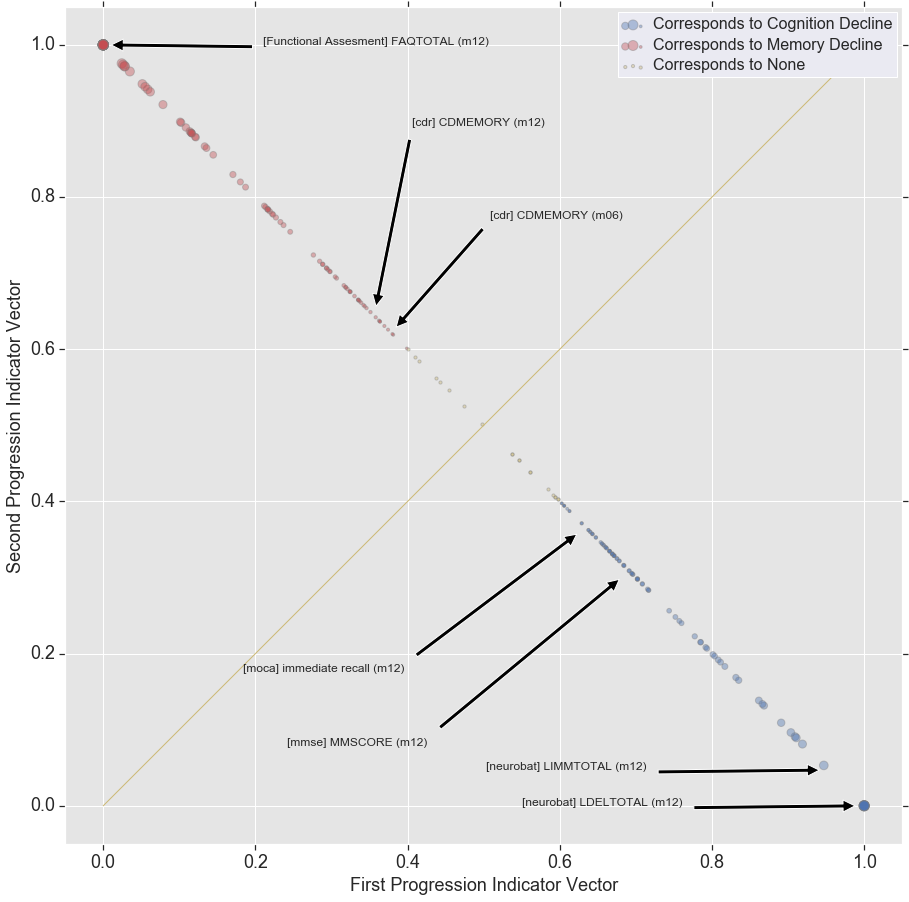

In [73]:
import seaborn as sns
%matplotlib auto
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)

M_H_T2_axis1 = M_H_T2[ M_H_T2['new'] == 'axis 1' ]
M_H_T2_axis2 = M_H_T2[ M_H_T2['new'] == 'axis 2' ]
M_H_T2_amb = M_H_T2[ M_H_T2['new'] == 'ambigious' ]
x_new = np.linspace(0, 1, 100)
y_new = x_new


fig3,ax3 = plt.subplots(figsize=(15, 15))

ax3.scatter(M_H_T2_axis1["axis 1"], M_H_T2_axis1["axis 2"],alpha = 0.4, s= (M_H_T2_axis1['axis 1']**5)*100,linewidth=1.0, cmap="Blues",color= 'b', edgecolors="grey",label='Corresponds to Cognition Decline')
ax3.scatter(M_H_T2_axis2["axis 1"], M_H_T2_axis2["axis 2"],alpha = 0.4, s= (M_H_T2_axis2['axis 2']**5)*100,linewidth=1.0,cmap="Oranges",color= 'r', edgecolors="grey",label='Corresponds to Memory Decline')
ax3.scatter(M_H_T2_amb["axis 1"], M_H_T2_amb["axis 2"],alpha = 0.4,s=10,linewidth=1.0,  edgecolors="grey",color= 'y',label='Corresponds to None')
ax3.plot(x_new, y_new, alpha = 1.0, linewidth = 1.0, color= 'y')
ax3.set_xlim([-0.05, 1.05])
ax3.set_ylim([-0.05, 1.05])
ax3.set_ylabel('Second Progression Indicator Vector',fontsize=18)
ax3.set_xlabel('First Progression Indicator Vector',fontsize=18)
ax3.annotate('[moca] immediate recall (m12)', xy=(0.634160998, 0.365839002), xytext=(0.634160998-0.45, 0.365839002-0.19),arrowprops=dict(facecolor='black', shrink=0.05))
#ax3.annotate('[moca] moca abstraction (m06)', xy=(0.665256847, 0.334743153), xytext=(0.665256847-0.45, 0.334743153-0.2),arrowprops=dict(facecolor='black', shrink=0.05))
ax3.annotate('[mmse] MMSCORE (m12)', xy=(0.69147672, 0.30852328), xytext=(0.69147672-0.45, 0.30852328-0.23),arrowprops=dict(facecolor='black', shrink=0.05))
ax3.annotate('[neurobat] LIMMTOTAL (m12)', xy=(0.95307042, 0.04692958), xytext=(0.95307042-0.45, 0.04692958),arrowprops=dict(facecolor='black', shrink=0.05))
ax3.annotate('[neurobat] LDELTOTAL (m12)', xy=(1.0, 0.0), xytext=(1.0-0.45, 0.0),arrowprops=dict(facecolor='black', shrink=0.05))

    
ax3.annotate('[cdr] CDMEMORY (m12)', xy=(0.355936585, 0.644063415), xytext=(0.355936585-0.1 + 0.15 , 0.644063415+ 0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax3.annotate('[cdr] CDMEMORY (m06)', xy=(0.378390075, 0.621609925), xytext=(0.378390075 + 0.13, 0.621609925+ 0.15),arrowprops=dict(facecolor='black', shrink=0.05))
#ax3.annotate('[ecogpt] memory (m12)', xy=(0.358086202, 0.641913798), xytext=(0.358086202 + 0.25, 0.641913798+ 0.20),arrowprops=dict(facecolor='black', shrink=0.05))
ax3.annotate('[Functional Assesment] FAQTOTAL (m12)', xy=(0.0, 1.0), xytext=(0.0+0.21, 1.0),arrowprops=dict(facecolor='black', shrink=0.05))
ax3 = plt.gca()
ax3.set_axis_bgcolor((0.898, 0.898, 0.898))
fig3 = plt.gcf()
ax3.tick_params(labelsize=18)
ax3.legend()
plt.setp(ax3.get_legend().get_texts(), fontsize='16')

plt.savefig(address + 'xyplot.png',dpi = 200)   

## cognition
#moca__moca_immediate_recall___m12_x	0.634160998	0.365839002
#moca__moca_abstraction___m06_x	0.665256847	0.334743153
#mmse__MMSCORE___m12	0.69147672	0.30852328
#neurobat__LIMMTOTAL___m12	0.95307042	0.04692958
#neurobat__LDELTOTAL___m12	1	0
##Memory
#cdr__CDMEMORY___m12	0.355936585	0.644063415
#cdr__CDMEMORY___m06	0.378390075	0.621609925
#ecogpt___memory_m06	0.344416666	0.655583334
#ecogpt___memory_m12	0.358086202	0.641913798
#FAQ__FAQTOTAL___m06	0	1
#FAQ__FAQTOTAL___m12	0	1
  
#######################################
# Apoe4 distribution in original classes
#######################################

#### Distribution of APOE4 in original class (Control, dementia ns MCI)

In [84]:
#######################################
# Apoe4 distribution in original classes
#######################################


redued = redued_item_24
cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])

apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ]  

redued = redued.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)

print( redued['APOE4'].value_counts(normalize=True) )

#0.0    258
#1.0    155
#2.0     40
#0.0    0.569536
#1.0    0.342163
#2.0    0.088300

print( redued['DXCHANGE'].value_counts(normalize=True) )

#2    197
#1    170
#3     86


print( redued[ redued['DXCHANGE'] == 1 ]['APOE4'].value_counts(normalize=True) )

#0.0    123
#1.0     44
#2.0      3
#2    0.434879
#1    0.375276
#3    0.189845

print( redued[ redued['DXCHANGE'] == 2 ]['APOE4'].value_counts(normalize=True) )

#0.0    112
#1.0     65
#2.0     20
#0.0    0.568528
#1.0    0.329949
#2.0    0.101523

print( redued[ redued['DXCHANGE'] == 3 ]['APOE4'].value_counts(normalize=True) )

#1.0    46
#0.0    23
#2.0    17
#1.0    0.534884
#0.0    0.267442
#2.0    0.197674


# import seaborn as sns
# a = redued.groupby(['DXCHANGE'])['APOE4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('DXCHANGE')
# p = sns.barplot(x="DXCHANGE", y="percentage", hue="APOE4", data=a)

0.0    0.599190
1.0    0.340081
2.0    0.060729
Name: APOE4, dtype: float64
1    0.441296
2    0.396761
3    0.161943
Name: DXCHANGE, dtype: float64
0.0    0.678899
1.0    0.311927
2.0    0.009174
Name: APOE4, dtype: float64
0.0    0.653061
1.0    0.285714
2.0    0.061224
Name: APOE4, dtype: float64
1.0    0.55
0.0    0.25
2.0    0.20
Name: APOE4, dtype: float64


#### Distribution of APOE4 in projected classes

Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
0    143
1     79
2     61
Name: 0, dtype: int64


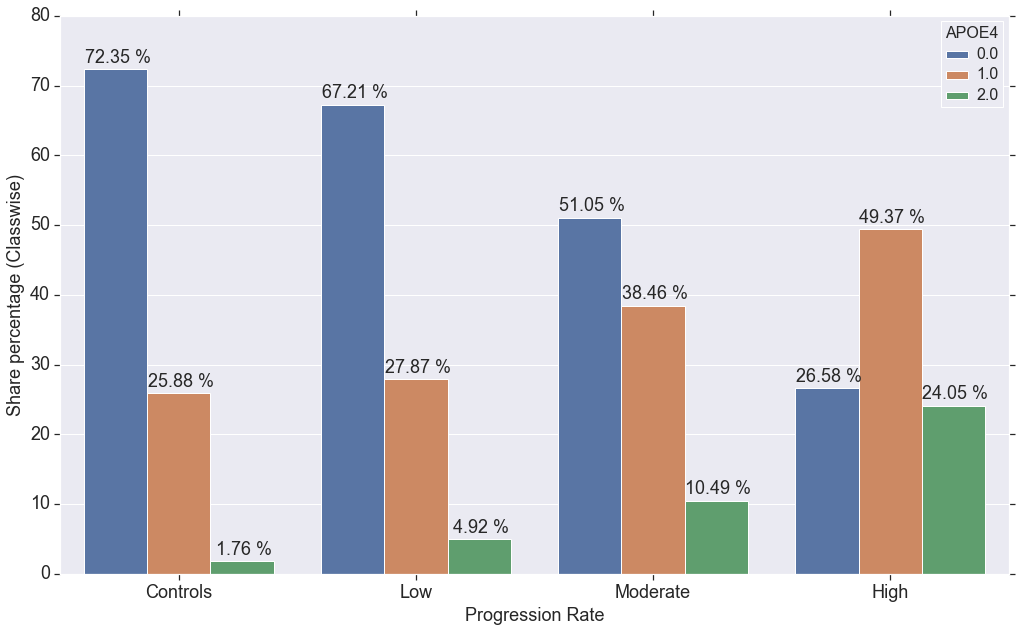

In [75]:
visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Control','MCI','Dementia'])


import seaborn as sns
redued = redued.rename(columns = {'predicted':'Progression Rate'})
plt.figure(figsize=(17, 10)) 
a = redued.groupby(['Progression Rate'])['APOE4'].value_counts(normalize=True).rename('Share percentage (Classwise)').mul(100).reset_index().sort_values('Progression Rate')
axis = sns.barplot(x="Progression Rate", y="Share percentage (Classwise)", hue="APOE4", order = ['Controls','Low','Moderate','High'] ,data=a)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
plt.setp(axis.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='16') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
    
plt.savefig(address + 'APOE4_dist_barplot_24.png',dpi = 200)   


Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
2    58
1    43
0    37
Name: 0, dtype: int64


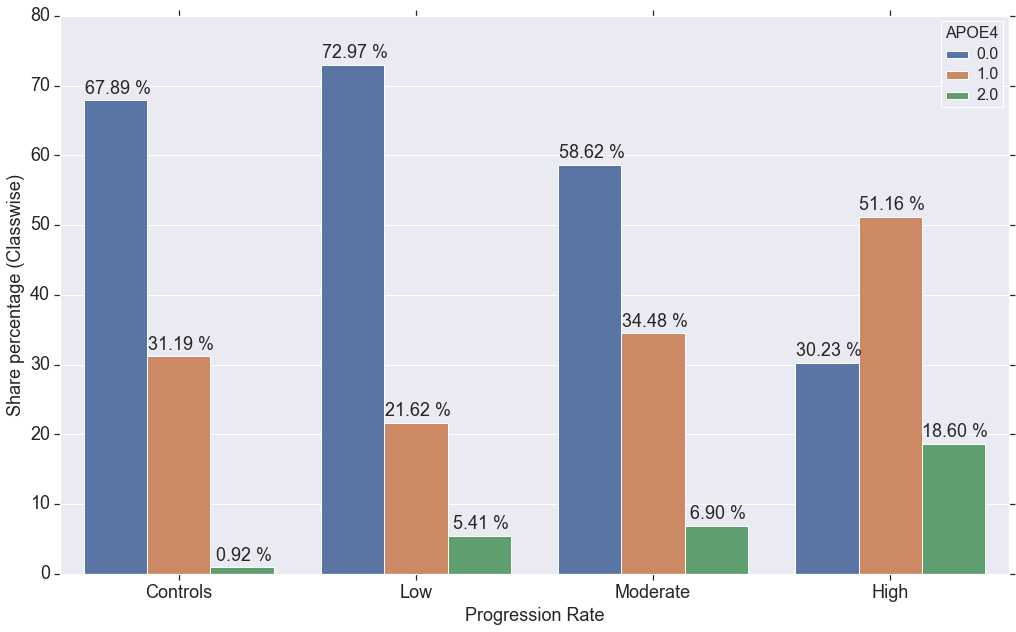

In [76]:
visits = 'm48'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Control','MCI','Dementia'])


import seaborn as sns
redued = redued.rename(columns = {'predicted':'Progression Rate'})
plt.figure(figsize=(17, 10)) 
a = redued.groupby(['Progression Rate'])['APOE4'].value_counts(normalize=True).rename('Share percentage (Classwise)').mul(100).reset_index().sort_values('Progression Rate')
axis = sns.barplot(x="Progression Rate", y="Share percentage (Classwise)", hue="APOE4", order = ['Controls','Low','Moderate','High'] ,data=a)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
plt.setp(axis.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='16') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
    
plt.savefig(address + 'APOE4_dist_barplot_48.png',dpi = 200)   


In [77]:
print( redued['APOE4'].value_counts(normalize=True) )

#0.0    135
#1.0    111
#2.0     37
#0.0    0.477032
#1.0    0.392226
#2.0    0.130742


print( redued['Progression Rate'].value_counts(normalize=True) )

#Medium    143
#High       79
#Low        61
#Medium    0.505300
#High      0.279152
#Low       0.215548

print( redued[ redued['Progression Rate'] == 'Controls' ]['APOE4'].value_counts() )

#0.0    123
#1.0     44
#2.0      3
#0.0    0.723529
#1.0    0.258824
#2.0    0.017647

print( redued[ redued['Progression Rate'] == 'Low' ]['APOE4'].value_counts(normalize=True) )

#0.0    41
#1.0    17
#2.0     3
#0.0    0.672131
#1.0    0.278689
#2.0    0.049180

print( redued[ redued['Progression Rate'] == 'Medium' ]['APOE4'].value_counts(normalize=True) )

#0.0    73
#1.0    55
#2.0    15
#0.0    0.510490
#1.0    0.384615
#2.0    0.104895

print( redued[ redued['Progression Rate'] == 'High' ]['APOE4'].value_counts(normalize=True) )

#1.0    39
#0.0    21
#2.0    19
#1.0    0.493671
#0.0    0.265823
#2.0    0.240506
a = redued.groupby(['Progression Rate'])['APOE4'].value_counts().rename('Count').reset_index().sort_values('Progression Rate')


0.0    0.599190
1.0    0.340081
2.0    0.060729
Name: APOE4, dtype: float64
Controls    0.441296
Moderate    0.234818
High        0.174089
Low         0.149798
Name: Progression Rate, dtype: float64
0.0    74
1.0    34
2.0     1
Name: APOE4, dtype: int64
0.0    0.729730
1.0    0.216216
2.0    0.054054
Name: APOE4, dtype: float64
Series([], Name: APOE4, dtype: float64)
1.0    0.511628
0.0    0.302326
2.0    0.186047
Name: APOE4, dtype: float64


#### Odds Ratio
Distribution of MCI and Dementia in low medium and high projections. 

Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
0    143
1     79
2     61
Name: 0, dtype: int64
Moderate    0.604061
Low         0.309645
High        0.086294
Name: Progression Rate, dtype: float64
High        62
Moderate    24
Name: Progression Rate, dtype: int64


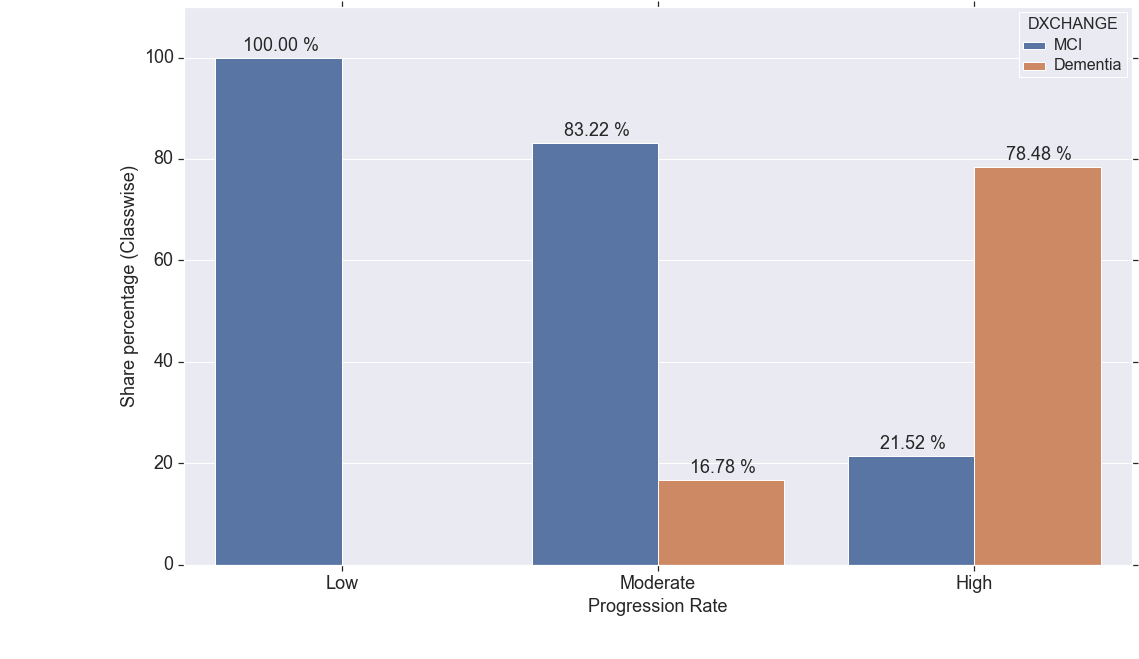

In [78]:
visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm

nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])


redued = redued.rename(columns = {'predicted':'Progression Rate'})
plt.figure(figsize=(17, 10)) 
a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts(normalize=True).rename('percentage (Classwise)').mul(100).reset_index().sort_values('DXCHANGE')
axis = sns.barplot(x="Progression Rate", y="percentage (Classwise)", hue="DXCHANGE", hue_order = ['MCI','Dementia']  , order = ['Low','Moderate','High'] ,data=a)

axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
axis.set_ylim( ([0,110]) )

plt.setp(axis.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='16') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
    
plt.savefig(address + 'oddsratio_dist_barplot_24.png',dpi = 200)   


a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts().rename('Count').reset_index().sort_values('Progression Rate')



a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts().rename('Count').reset_index().sort_values('Progression Rate')

print( redued[ redued['DXCHANGE'] == 'MCI' ]['Progression Rate'].value_counts(normalize=True) )

# Medium    0.604061
# Low       0.309645
# High      0.086294
# Medium    119
# Low        61
# High       17

print( redued[ redued['DXCHANGE'] == 'Dementia' ]['Progression Rate'].value_counts() )

# High      0.72093
# Medium    0.27907
# High      62
# Medium    24


Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
2    58
1    43
0    37
Name: 0, dtype: int64
Moderate    0.479592
Low         0.377551
High        0.142857
Name: Progression Rate, dtype: float64
High        29
Moderate    11
Name: Progression Rate, dtype: int64


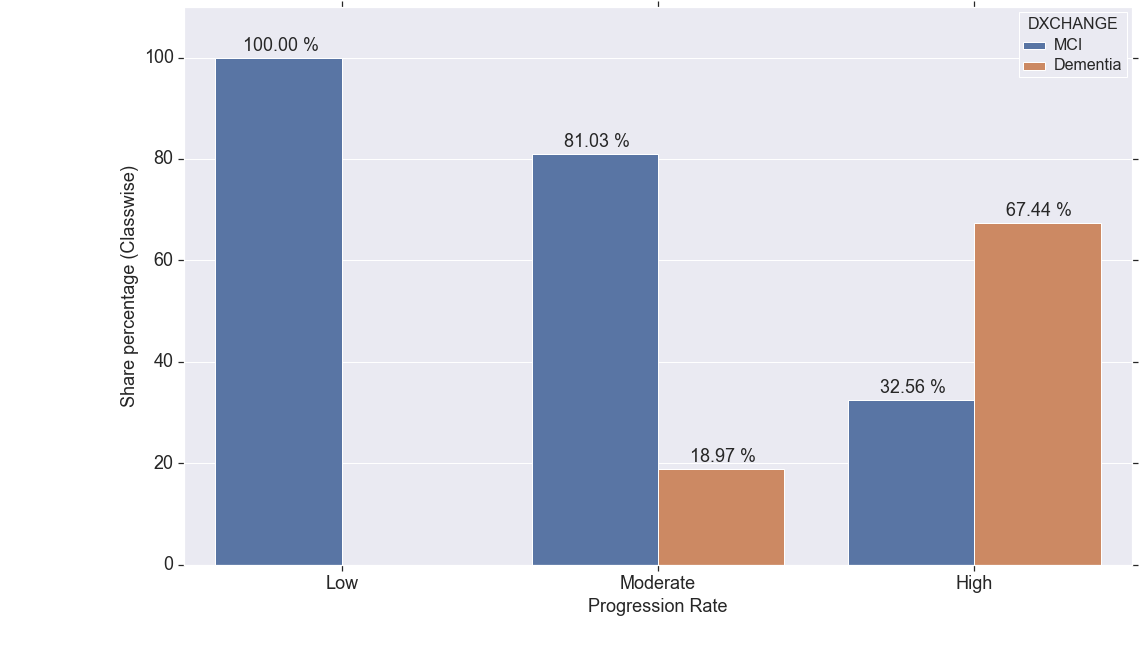

In [79]:
visits = 'm48'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm

nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])


redued = redued.rename(columns = {'predicted':'Progression Rate'})
plt.figure(figsize=(17, 10)) 
a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts(normalize=True).rename('percentage (Classwise)').mul(100).reset_index().sort_values('DXCHANGE')
axis = sns.barplot(x="Progression Rate", y="percentage (Classwise)", hue="DXCHANGE", hue_order = ['MCI','Dementia']  , order = ['Low','Moderate','High'] ,data=a)

axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("Share percentage (Classwise)",fontsize=18)
axis.set_ylim( ([0,110]) )

plt.setp(axis.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='16') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
    
plt.savefig(address + 'oddsratio_dist_barplot_48.png',dpi = 200)   


a = redued.groupby(['Progression Rate'])['DXCHANGE'].value_counts().rename('Count').reset_index().sort_values('Progression Rate')

print( redued[ redued['DXCHANGE'] == 'MCI' ]['Progression Rate'].value_counts(normalize=True) )

# Medium    0.604061
# Low       0.309645
# High      0.086294
# Medium    119
# Low        61
# High       17

print( redued[ redued['DXCHANGE'] == 'Dementia' ]['Progression Rate'].value_counts() )

# High      0.72093
# Medium    0.27907
# High      62
# Medium    24


#### MMSE and GD Scale as per different progression rate

Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
Start...
(583, 218)
PCA done
ICA done
NMF done
0    143
1     79
2     61
Name: 0, dtype: int64


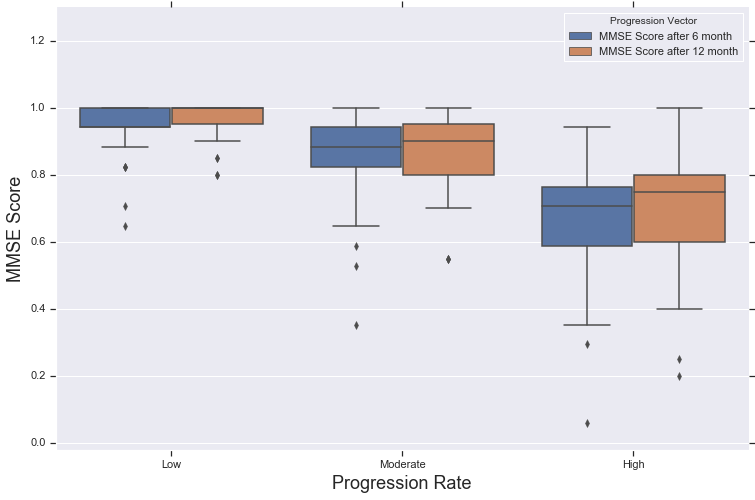

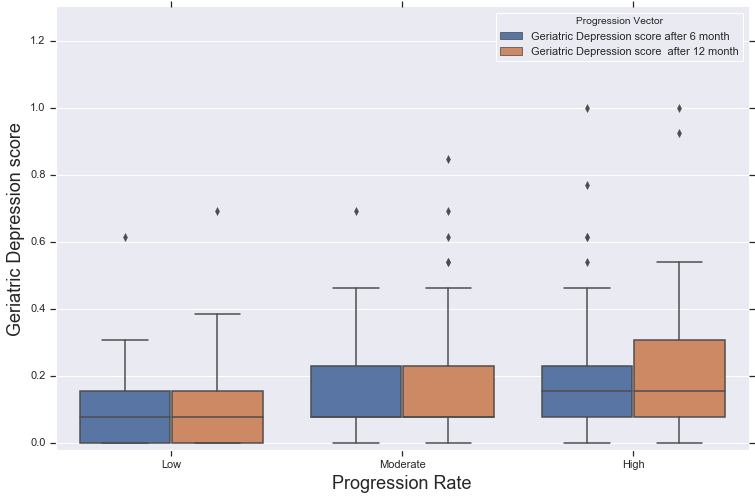

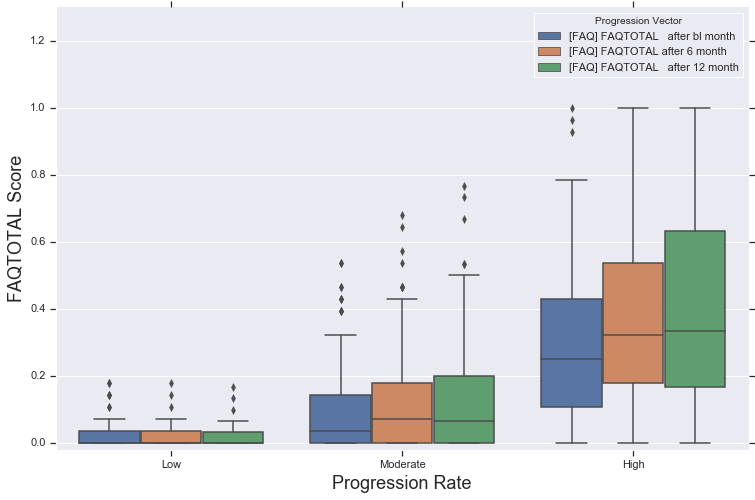

In [80]:
visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
_, M_chosen = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(M_chosen[['FAQ__FAQTOTAL___m06','FAQ__FAQTOTAL___bl','FAQ__FAQTOTAL___m12', 'mmse__MMSCORE___m06','mmse__MMSCORE___m12','gd_scale__GDTOTAL___m06','gd_scale__GDTOTAL___m12']], left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])

redued_2 = redued[['mmse__MMSCORE___m06','predicted']]
redued_2['Progression Vector'] = 'MMSE Score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['mmse__MMSCORE___m12','predicted']]
redued_1['Progression Vector'] = 'MMSE Score after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order = ['MMSE Score after 6 month','MMSE Score after 12 month' ],  order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("MMSE Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_mmse_24.png',dpi = 200)   
    
redued_2 = redued[['gd_scale__GDTOTAL___m06','predicted']]
redued_2['Progression Vector'] = 'Geriatric Depression score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['gd_scale__GDTOTAL___m12','predicted']]
redued_1['Progression Vector'] = 'Geriatric Depression score  after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val",hue_order = ['Geriatric Depression score after 6 month','Geriatric Depression score  after 12 month'], order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Geriatric Depression score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_gd_24.png',dpi = 200)   
    
redued_2 = redued[['FAQ__FAQTOTAL___m06','predicted']]
redued_2['Progression Vector'] = '[FAQ] FAQTOTAL after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['FAQ__FAQTOTAL___m12','predicted']]
redued_1['Progression Vector'] = '[FAQ] FAQTOTAL   after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_3 = redued[['FAQ__FAQTOTAL___bl','predicted']]
redued_3['Progression Vector'] = '[FAQ] FAQTOTAL   after bl month'
redued_3.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2,redued_3])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order =  ['[FAQ] FAQTOTAL   after bl month','[FAQ] FAQTOTAL after 6 month','[FAQ] FAQTOTAL   after 12 month'], order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("FAQTOTAL Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_faq_24.png',dpi = 200)   

Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
Start...
(583, 218)
PCA done
ICA done
NMF done
2    58
1    43
0    37
Name: 0, dtype: int64


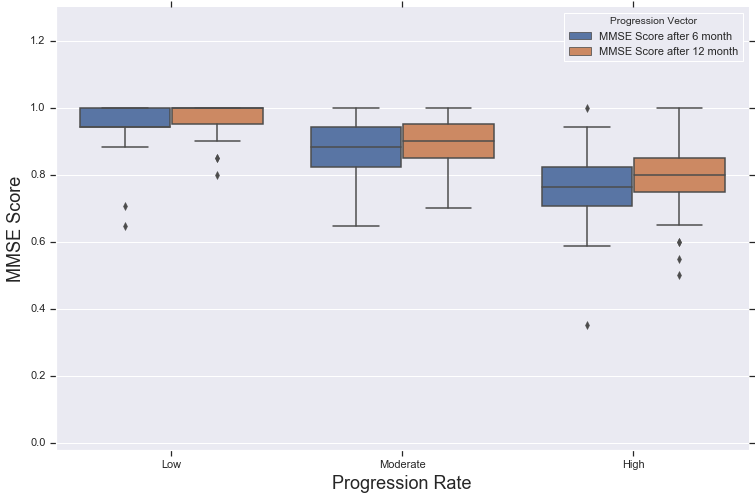

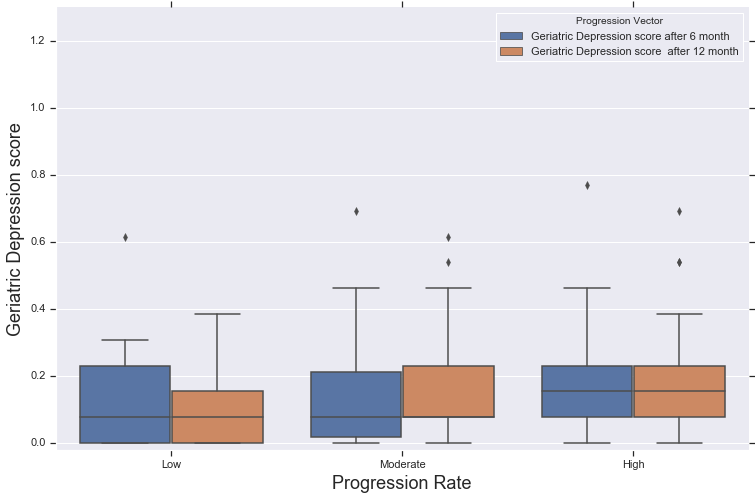

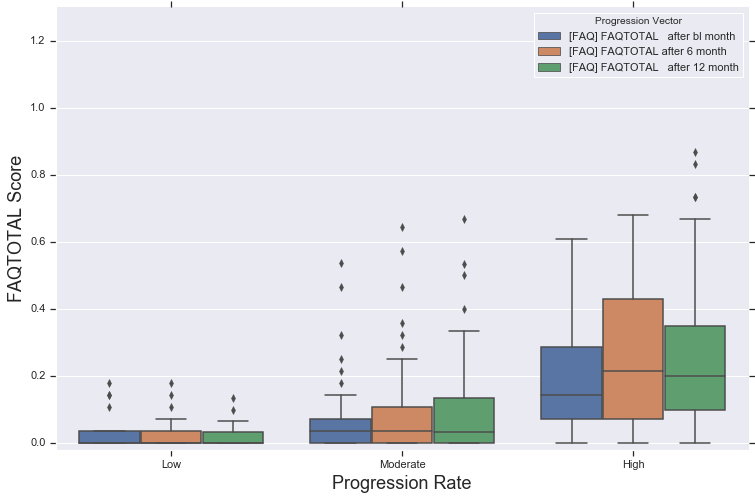

In [81]:
visits = 'm48'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
_, M_chosen = project_data2(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(M_chosen[['FAQ__FAQTOTAL___m06','FAQ__FAQTOTAL___bl','FAQ__FAQTOTAL___m12', 'mmse__MMSCORE___m06','mmse__MMSCORE___m12','gd_scale__GDTOTAL___m06','gd_scale__GDTOTAL___m12']], left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])

redued_2 = redued[['mmse__MMSCORE___m06','predicted']]
redued_2['Progression Vector'] = 'MMSE Score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['mmse__MMSCORE___m12','predicted']]
redued_1['Progression Vector'] = 'MMSE Score after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order = ['MMSE Score after 6 month','MMSE Score after 12 month' ],  order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("MMSE Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_mmse_48.png',dpi = 200)   
    
redued_2 = redued[['gd_scale__GDTOTAL___m06','predicted']]
redued_2['Progression Vector'] = 'Geriatric Depression score after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['gd_scale__GDTOTAL___m12','predicted']]
redued_1['Progression Vector'] = 'Geriatric Depression score  after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val",hue_order = ['Geriatric Depression score after 6 month','Geriatric Depression score  after 12 month'], order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Geriatric Depression score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_gd_48.png',dpi = 200)   
    
redued_2 = redued[['FAQ__FAQTOTAL___m06','predicted']]
redued_2['Progression Vector'] = '[FAQ] FAQTOTAL after 6 month'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['FAQ__FAQTOTAL___m12','predicted']]
redued_1['Progression Vector'] = '[FAQ] FAQTOTAL   after 12 month'
redued_1.columns = ['val','predicted','Progression Vector']
redued_3 = redued[['FAQ__FAQTOTAL___bl','predicted']]
redued_3['Progression Vector'] = '[FAQ] FAQTOTAL   after bl month'
redued_3.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2,redued_3])

axis = sns.factorplot("predicted", hue="Progression Vector", y="val", hue_order =  ['[FAQ] FAQTOTAL   after bl month','[FAQ] FAQTOTAL after 6 month','[FAQ] FAQTOTAL   after 12 month'], order =  ['Low','Moderate','High'],data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("FAQTOTAL Score",fontsize=18)
    ax.set_ylim( ([-0.02,1.3])  )
plt.savefig(address + 'ppmi_type_faq_48.png',dpi = 200)   

### Normalized axis dimension vs projection rate
For 24$^{th}$ month

Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
0    143
1     79
2     61
Name: 0, dtype: int64


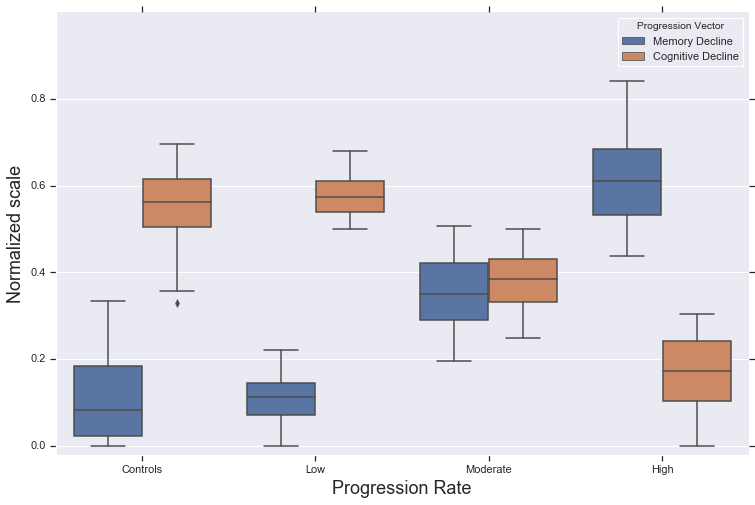

In [82]:

visits = 'm24'
%matplotlib inline
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])


redued_2 = redued[['NMF_2_1','predicted']]
redued_2['Progression Vector'] = 'Cognitive Decline'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['NMF_2_2','predicted']]
redued_1['Progression Vector'] = 'Memory Decline'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])


axis = sns.factorplot("predicted", hue="Progression Vector", y="val", order =  ['Controls', 'Low','Moderate','High'], data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Normalized scale",fontsize=18)
    ax.set_ylim( ([-0.02,1])   )
plt.savefig(address + 'ppmi_type_24.png',dpi = 200)

### Normalized axis dimension vs projection rate
For 48$^{th}$ month

Using matplotlib backend: Qt5Agg
Start...
Shape of dataset is (583, 218)
PCA done
ICA Done
NMF Done
End...
2    58
1    43
0    37
Name: 0, dtype: int64


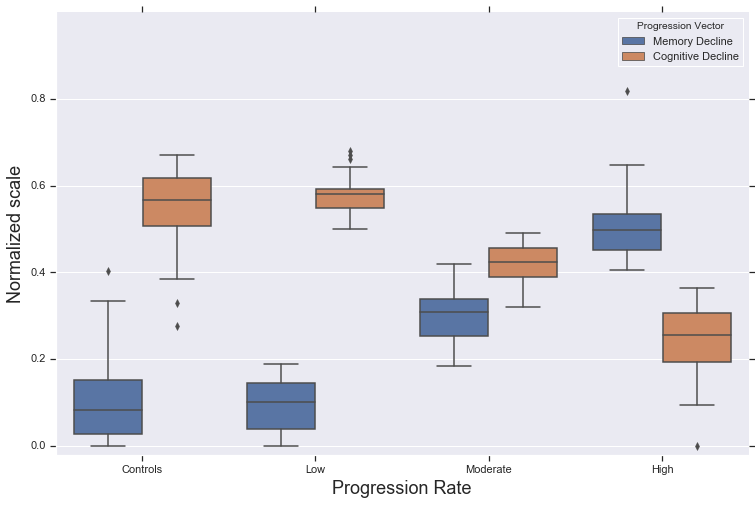

In [83]:

visits = 'm48'
%matplotlib auto
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
    
    
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)


from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())
Predict_gmm.columns = ['predicted']
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)
M_mci_dem_nmf_proj['predicted'] = Predict_gmm
#plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')    
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)

cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\ADNI\\Raw_Data\\Assessment\\apoe4\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])
apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m24']) ] 
Predict_gmm = data_prediction_labels
redued = Predict_gmm.merge(apoe4['APOE4'].to_frame(), left_index=True, right_index=True)
redued = redued.merge(redued_item_24['DXCHANGE'].to_frame(), left_index=True, right_index=True)

redued['predicted'] = redued['predicted'].replace([0,1,2,3],['Low','Moderate','High','Controls'])
redued['DXCHANGE'] = redued['DXCHANGE'].replace([1,2,3],['Controls','MCI','Dementia'])


redued_2 = redued[['NMF_2_1','predicted']]
redued_2['Progression Vector'] = 'Cognitive Decline'
redued_2.columns = ['val','predicted','Progression Vector']
redued_1 = redued[['NMF_2_2','predicted']]
redued_1['Progression Vector'] = 'Memory Decline'
redued_1.columns = ['val','predicted','Progression Vector']
redued_new = pd.concat([redued_1,redued_2])


axis = sns.factorplot("predicted", hue="Progression Vector", y="val", order =  ['Controls', 'Low','Moderate','High'], data=redued_new,size =7, aspect = 1.5, kind="box",legend_out=False)
for ax in axis.axes.flat:
    ax.set_xlabel("Progression Rate",fontsize=18)
    ax.set_ylabel("Normalized scale",fontsize=18)
    ax.set_ylim( ([-0.02,1])   )
plt.savefig(address + 'ppmi_type_48.png',dpi = 200)